# Microstate Analysis

## Spatial Correlation

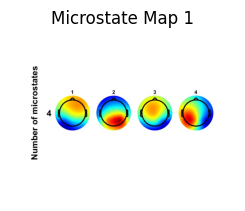

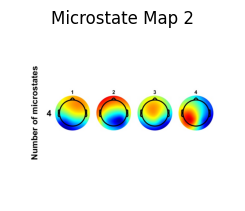

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "resting_2000_1.jpg"
image = Image.open(image_path)

image_path2 = "resting_2000_2.jpg"
image2 = Image.open(image_path2)

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Microstate Map 1")
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(image2)
plt.axis("off")
plt.title("Microstate Map 2")
plt.show()


In [2]:
# Convert to grayscale and crop each microstate map
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr

grayscale_image = image.convert("L")
grayscale_image2 = image2.convert("L")

x_offset = [0,160,320,480]

# x,y,w,h = 0,25,90,110

for i in range(1):
    x1,y1 = 170 + x_offset[i],245
    x2,y2 = 310 + x_offset[i],390
    microstate1 = grayscale_image.crop((x1, y1, x2, y2))  # Replace with actual coordinates
    microstate2 = grayscale_image2.crop((x1, y1, x2, y2))  # Example for another map

    # Convert cropped images to arrays
    microstate1_array = np.array(microstate1)
    microstate2_array = np.array(microstate2)

    # Display cropped microstates
    # plt.subplot(1, 2, 1)
    # plt.imshow(microstate1_array, cmap="gray")
    # plt.title("Microstate 1")
    # plt.axis("off")

    # plt.subplot(1, 2, 2)
    # plt.imshow(microstate2_array, cmap="gray")
    # plt.title("Microstate 2")
    # plt.axis("off")
    # plt.show()

    map1_flatten = microstate1_array.flatten()
    map2_flatten = microstate2_array.flatten()

    # Compute Pearson Correlation
    pearson_corr, _ = pearsonr(map1_flatten, map2_flatten)
    print(f"Pearson Correlation for Microstate {i+1} : {pearson_corr}")

    # Compute SSIM
    similarity_index, _ = ssim(microstate1_array, microstate2_array, full=True)
    print(f"SSIM for Microstate {i+1} : {similarity_index}")


Pearson Correlation for Microstate 1 : 0.9989678679589675
SSIM for Microstate 1 : 0.9886865024176967


## Finding the ideal Resting Template

There are following steps to find the ideal resting template:
- Load all images in `Microstates_Resting_Movement_Comparison/RestingCode_1000`, You can change the folder name in the code below.
- Calculate the correlation and ssim between all images.
- Then mode range is considered which varies from 0.9-1, 0.8-0.9, 0.7-0.8, 0.6-0.7, 0.5-0.6, 0.4-0.5, 0.3-0.4, 0.2-0.3, 0.1-0.2, 0-0.1.
- The mode range means the most occurence of the values in the range.
- The mode range with the highest number of occurence is considered as the ideal resting template.
- Then those values are used to calculate the correlation and ssim with all the images.
- Then average is considered in the filtered range.
- The highest average is considered as the ideal resting template.

In [7]:
import os
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
from collections import Counter

# Directory containing PNG files
input_directory = "Microstates_Resting_Movement_Comparison/RestingCode_1000"

# Get list of all PNG files in the directory
png_files = [f for f in os.listdir(input_directory) if f.endswith('.png')]

if len(png_files) < 2:
    raise ValueError("Not enough PNG files in the directory to perform the task.")

# Function to calculate SSIM and Pearson correlation
def calculate_metrics(image1_path, image2_path):
    image1 = Image.open(image1_path).convert("L")
    image2 = Image.open(image2_path).convert("L")

    x_offsets = [0, 160, 320, 480]
    pearson_correlations = []
    ssim_values = []

    for i in range(4):  # Loop over offsets (modify as needed)
        x1, y1 = 170 + x_offsets[i], 245
        x2, y2 = 310 + x_offsets[i], 390

        microstate1 = image1.crop((x1, y1, x2, y2))
        microstate2 = image2.crop((x1, y1, x2, y2))

        # Convert cropped images to arrays
        microstate1_array = np.array(microstate1)
        microstate2_array = np.array(microstate2)

        # Flatten arrays
        map1_flatten = microstate1_array.flatten()
        map2_flatten = microstate2_array.flatten()

        # Compute Pearson Correlation
        pearson_corr, _ = pearsonr(map1_flatten, map2_flatten)
        pearson_correlations.append(pearson_corr)

        # Compute SSIM
        similarity_index, _ = ssim(microstate1_array, microstate2_array, full=True)
        ssim_values.append(similarity_index)

    # Return metrics
    # ssim_values = np.mean(ssim_values)
    # pearson_correlations = np.mean(pearson_correlations)
    return ssim_values, pearson_correlations

# Function to calculate the mode range
def calculate_mode_range(values, range_step=0.1):
    bins = [round(i * range_step, 1) for i in range(int(1 / range_step) + 1)]
    binned_values = [(value // range_step) * range_step for value in values]
    count = Counter(binned_values)
    mode_range = max(count, key=count.get)
    return mode_range, mode_range + range_step

# Dictionary to store metrics for each file
file_metrics = {}

# Loop through every file pair
for i, file1 in enumerate(png_files):
    file1_path = os.path.join(input_directory, file1)

    ssim_scores = []
    pearson_scores = []

    for j, file2 in enumerate(png_files):
        if i == j:
            continue

        file2_path = os.path.join(input_directory, file2)
        ssim_values, pearson_values = calculate_metrics(file1_path, file2_path)

        ssim_scores.extend(ssim_values)
        pearson_scores.extend(pearson_values)

    # Calculate mode range and filter outliers
    ssim_mode_range = calculate_mode_range(ssim_scores)
    pearson_mode_range = calculate_mode_range(pearson_scores)

    filtered_ssim = [val for val in ssim_scores if ssim_mode_range[0] <= val < ssim_mode_range[1]]
    filtered_pearson = [val for val in pearson_scores if pearson_mode_range[0] <= val < pearson_mode_range[1]]

    # Store the mode range filtered metrics
    file_metrics[file1] = {
        "ssim_mode_range": ssim_mode_range,
        "pearson_mode_range": pearson_mode_range,
        "filtered_ssim_avg": np.mean(filtered_ssim) if filtered_ssim else 0,
        "filtered_pearson_avg": np.mean(filtered_pearson) if filtered_pearson else 0
    }

    print(f"Processed {file1}")

# Find the file with the highest filtered averages
best_file = max(file_metrics.items(), key=lambda x: (x[1]["filtered_ssim_avg"], x[1]["filtered_pearson_avg"]))

# Report the results
print("File with highest filtered average SSIM and Pearson correlation:")
print(f"File Name: {best_file[0]}")
print(f"Filtered Average SSIM: {best_file[1]['filtered_ssim_avg']}")
print(f"Filtered Average Pearson Correlation: {best_file[1]['filtered_pearson_avg']}")


Processed Map_1.png
Processed Map_10.png
Processed Map_11.png
Processed Map_12.png
Processed Map_13.png
Processed Map_15.png
Processed Map_16.png
Processed Map_17.png
Processed Map_18.png
Processed Map_19.png
Processed Map_2.png
Processed Map_20.png
Processed Map_21.png
Processed Map_22.png
Processed Map_23.png
Processed Map_25.png
Processed Map_26.png
Processed Map_27.png
Processed Map_29.png
Processed Map_3.png
Processed Map_30.png
Processed Map_32.png
Processed Map_33.png
Processed Map_34.png
Processed Map_4.png
Processed Map_6.png
Processed Map_7.png
Processed Map_8.png
Processed Map_9.png
Processed Map_stat_1.png
Processed Map_stat_10.png
Processed Map_stat_11.png
Processed Map_stat_12.png
Processed Map_stat_13.png
Processed Map_stat_15.png
Processed Map_stat_16.png
Processed Map_stat_17.png
Processed Map_stat_18.png
Processed Map_stat_19.png
Processed Map_stat_2.png
Processed Map_stat_20.png
Processed Map_stat_21.png
Processed Map_stat_22.png
Processed Map_stat_23.png
Processed M

Thus `Map_7.png` represents closest to the ideal resting template.

## Taking the ideal resting template and calculating the correlation and ssim with all the images.

In [14]:
import os
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from collections import Counter
import pandas as pd


# Predefined paths
base_image_path = "Microstates_Resting_Movement_Comparison/RestingCode_1000/Map_7.png"
output_directory = "Microstates_Resting_Movement_Comparison/outputFEL1000"

# Function to calculate SSIM for a given pair of images
def calculate_ssim(image1_path, image2_path):
    image1 = Image.open(image1_path).convert("L")
    image2 = Image.open(image2_path).convert("L")

    x_offsets = [0, 160, 320, 480]
    ssim_values = []

    for i in range(4):  # Loop over offsets
        x1, y1 = 170 + x_offsets[i], 245
        x2, y2 = 310 + x_offsets[i], 390

        microstate1 = image1.crop((x1, y1, x2, y2))
        microstate2 = image2.crop((x1, y1, x2, y2))

        # Convert cropped images to arrays
        microstate1_array = np.array(microstate1)
        microstate2_array = np.array(microstate2)

        # Compute SSIM
        similarity_index, _ = ssim(microstate1_array, microstate2_array, full=True)
        ssim_values.append(similarity_index)

    # Return SSIM values per microstate
    return ssim_values

# Function to calculate the mode range
def calculate_mode_range(values, range_step=0.1):
    bins = [round(i * range_step, 1) for i in range(int(1 / range_step) + 1)]
    binned_values = [(value // range_step) * range_step for value in values]
    count = Counter(binned_values)
    mode_range = max(count, key=count.get)
    return mode_range, mode_range + range_step


# Categories for analysis
categories = {"pre_analysis": "_1.png", "event_analysis": "_2.png", "post_analysis": "_3.png"}

# Results storage
analysis_results = {}

# Perform analysis for each category
for analysis_label, suffix in categories.items():
    category_files = [f for f in os.listdir(output_directory) if f.endswith(suffix)]

    if not category_files:
        raise ValueError(f"No files found for {analysis_label} with suffix {suffix}.")

    ssim_scores_per_microstate = {f"Microstate_{i+1}": [] for i in range(4)}

    for file in category_files:
        file_path = os.path.join(output_directory, file)
        ssim_values = calculate_ssim(base_image_path, file_path)

        for i, value in enumerate(ssim_values):
            ssim_scores_per_microstate[f"Microstate_{i+1}"].append(value)

    # Calculate mode range and filtered averages for each microstate
    filtered_results = {}

    for microstate, scores in ssim_scores_per_microstate.items():
        mode_range = calculate_mode_range(scores)
        mode_range = (round(mode_range[0], 2), round(mode_range[1], 2))
        filtered_scores = [val for val in scores if mode_range[0] <= val < mode_range[1]]
        filtered_results[microstate] = {
            "mode_range": mode_range,
            "filtered_ssim_avg": np.mean(filtered_scores) if filtered_scores else 0
        }

    # Store results for the analysis type
    analysis_results[analysis_label] = filtered_results

# Display results in tabular format
for label, results in analysis_results.items():
    print(f"{label.capitalize()} Analysis Results:")
    table_data = []
    for microstate, metrics in results.items():
        table_data.append([
            microstate,
            f"{metrics['mode_range'][0]}-{metrics['mode_range'][1]}",
            metrics['filtered_ssim_avg']
        ])

    df = pd.DataFrame(table_data, columns=["Microstate", "Mode Range", "Filtered SSIM Avg"])
    print(df)
    print()


Pre_analysis Analysis Results:
     Microstate Mode Range  Filtered SSIM Avg
0  Microstate_1    0.4-0.5           0.436568
1  Microstate_2    0.3-0.4           0.361666
2  Microstate_3    0.3-0.4           0.362228
3  Microstate_4    0.3-0.4           0.348296

Event_analysis Analysis Results:
     Microstate Mode Range  Filtered SSIM Avg
0  Microstate_1    0.4-0.5           0.427528
1  Microstate_2    0.3-0.4           0.371194
2  Microstate_3    0.3-0.4           0.358101
3  Microstate_4    0.3-0.4           0.354903

Post_analysis Analysis Results:
     Microstate Mode Range  Filtered SSIM Avg
0  Microstate_1    0.4-0.5           0.435409
1  Microstate_2    0.3-0.4           0.363079
2  Microstate_3    0.3-0.4           0.358587
3  Microstate_4    0.3-0.4           0.348829



In [16]:
import os
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from collections import Counter
import pandas as pd

# Predefined paths
base_image_path = "Microstates_Resting_Movement_Comparison/RestingCode_1000/Map_7.png"
output_directories = [
    "Microstates_Resting_Movement_Comparison/outputFEL1000",
    "Microstates_Resting_Movement_Comparison/outputFER1000",
    "Microstates_Resting_Movement_Comparison/outputTPL1000",
    "Microstates_Resting_Movement_Comparison/outputTPR1000",
    "Microstates_Resting_Movement_Comparison/outputFTL1000",
    "Microstates_Resting_Movement_Comparison/outputFTR1000"
]

# Function to calculate SSIM for a given pair of images
def calculate_ssim(image1_path, image2_path):
    image1 = Image.open(image1_path).convert("L")
    image2 = Image.open(image2_path).convert("L")

    x_offsets = [0, 160, 320, 480]
    ssim_values = []

    for i in range(4):  # Loop over offsets
        x1, y1 = 170 + x_offsets[i], 245
        x2, y2 = 310 + x_offsets[i], 390

        microstate1 = image1.crop((x1, y1, x2, y2))
        microstate2 = image2.crop((x1, y1, x2, y2))

        # Convert cropped images to arrays
        microstate1_array = np.array(microstate1)
        microstate2_array = np.array(microstate2)

        # Compute SSIM
        similarity_index, _ = ssim(microstate1_array, microstate2_array, full=True)
        ssim_values.append(similarity_index)

    # Return SSIM values per microstate
    return ssim_values

# Function to calculate the mode range
def calculate_mode_range(values, range_step=0.1):
    bins = [round(i * range_step, 1) for i in range(int(1 / range_step) + 1)]
    binned_values = [(value // range_step) * range_step for value in values]
    count = Counter(binned_values)
    mode_range = max(count, key=count.get)
    return mode_range, mode_range + range_step

# Categories for analysis
categories = {"pre_analysis": "_1.png", "event_analysis": "_2.png", "post_analysis": "_3.png"}

# Results storage
final_results = {category: [] for category in categories}

# Perform analysis for each directory
for directory in output_directories:
    directory_label = directory.split('/')[-1].replace("output", "")

    for analysis_label, suffix in categories.items():
        category_files = [f for f in os.listdir(directory) if f.endswith(suffix)]

        if not category_files:
            raise ValueError(f"No files found for {analysis_label} in {directory} with suffix {suffix}.")

        ssim_scores_per_microstate = {f"Microstate_{i+1}": [] for i in range(4)}

        for file in category_files:
            file_path = os.path.join(directory, file)
            ssim_values = calculate_ssim(base_image_path, file_path)

            for i, value in enumerate(ssim_values):
                ssim_scores_per_microstate[f"Microstate_{i+1}"].append(value)

        # Calculate mode range and filtered averages for each microstate
        filtered_results = {}

        for microstate, scores in ssim_scores_per_microstate.items():
            mode_range = calculate_mode_range(scores)
            mode_range = (round(mode_range[0], 2), round(mode_range[1], 2))
            filtered_scores = [val for val in scores if mode_range[0] <= val < mode_range[1]]
            filtered_results[microstate] = {
                "mode_range": mode_range,
                "filtered_ssim_avg": np.mean(filtered_scores) if filtered_scores else 0
            }

        # Append results to final table
        for microstate, metrics in filtered_results.items():
            row_label = f"{analysis_label}_{microstate[-1]}"
            final_results[analysis_label].append({
                "Directory": directory_label,
                "Microstate": microstate,
                "Mode Range": f"{metrics['mode_range'][0]}-{metrics['mode_range'][1]}",
                "Filtered SSIM Avg": metrics['filtered_ssim_avg']
            })

# Combine and display results
for analysis_label, data in final_results.items():
    print(f"{analysis_label.capitalize()} Analysis Results:")

    df = pd.DataFrame(data, columns=["Directory", "Microstate", "Mode Range", "Filtered SSIM Avg"])
    df_pivot = df.pivot(index="Microstate", columns="Directory", values="Filtered SSIM Avg")

    print(df_pivot)
    print()
    df_pivot.to_csv(f"{analysis_label}_analysis_results.csv")


Pre_analysis Analysis Results:
Directory      FEL1000   FER1000   FTL1000   FTR1000   TPL1000   TPR1000
Microstate                                                              
Microstate_1  0.436568  0.423680  0.431937  0.441131  0.422233  0.444348
Microstate_2  0.361666  0.430481  0.428088  0.429749  0.425484  0.442081
Microstate_3  0.362228  0.360640  0.436466  0.440683  0.354016  0.449606
Microstate_4  0.348296  0.350565  0.360720  0.345169  0.365873  0.367796

Event_analysis Analysis Results:
Directory      FEL1000   FER1000   FTL1000   FTR1000   TPL1000   TPR1000
Microstate                                                              
Microstate_1  0.427528  0.429148  0.434268  0.438067  0.419156  0.439559
Microstate_2  0.371194  0.371657  0.435746  0.426394  0.426590  0.371463
Microstate_3  0.358101  0.357235  0.451725  0.442650  0.362246  0.366746
Microstate_4  0.354903  0.355761  0.359340  0.431499  0.363078  0.360592

Post_analysis Analysis Results:
Directory      FEL1000   F